Load results file with pandas

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('/home/gerard/ownCloud/varis_tesi/WSD_Evaluation_Framework/Evaluation_Datasets/senseval2/results.txt', sep='\t')

In [107]:
df = df.assign(tp=(df['system'] == 1) & (df['gold'] == 1))
df = df.assign(fp=(df['system'] == 1) & (df['gold'] == 0))
df = df.assign(fn=(df['system'] == 0) & (df['gold'] == 1))
df = df.assign(tn=(df['system'] == 0) & (df['gold'] == 0))
df.head()


,mention,candidate,gold,system,bias,rank,tp,fp,fn,tn
0,"d000.s000.t000_(1,2)_art",2743547,0,0,0.0029,0.8811,False,False,False,True
1,"d000.s000.t000_(1,2)_art",933420,0,1,0.6986,0.7873,False,True,False,False
2,"d000.s000.t000_(1,2)_art",5638987,1,0,0.6981,0.8035,False,False,True,False
3,"d000.s000.t000_(1,2)_art",6998748,0,0,0.0001,0.5335,False,False,False,True
4,"d000.s000.t001_(3,4)_change-ringing",544605,1,1,0.9997,0.9309,True,False,False,False


In [165]:
# group rows by mention and, for each mention, get maximum score and a flag indicating if one of the mention senses is a true positive
mention_groups = df.groupby('mention')
mentions2scores = mention_groups['bias'].max()
mentions2tp = mention_groups['tp'].agg(any).astype(int)

mf = pd.DataFrame({'max_scores': mentions2scores, 'mentions_tp': mentions2tp})
# group max scores into 4 bins
mf['binned_scores'] = pd.qcut(mf['max_scores'], 20, duplicates='drop')

print(mf.head())
print()
print(mf['binned_scores'].value_counts())

binned_scores_groups = mf.groupby('binned_scores')
tp_per_score_group = binned_scores_groups['mentions_tp'].mean()
print()
print(tp_per_score_group)

                                     max_scores  mentions_tp     binned_scores
mention                                                                       
d000.s000.t000_(1,2)_art                 0.6986            0  (0.6886, 0.8873]
d000.s000.t001_(3,4)_change-ringing      0.9997            1  (0.9996, 0.9998]
d000.s000.t002_(5,6)_peculiar            0.8754            1  (0.6886, 0.8873]
d000.s000.t003_(8,9)_English             0.6623            1  (0.1865, 0.6886]
d000.s000.t004_(13,14)_most              0.9979            1  (0.9977, 0.9987]

(0.9999, 1.0]         351
(0.9998, 0.9999]      147
(0.9992, 0.9996]      141
(0.9996, 0.9998]      137
(0.9961, 0.9977]      117
(0.9935, 0.9961]      114
(0.8873, 0.9454]      113
(0.9977, 0.9987]      113
(0.02178, 0.1865]     112
(0.6886, 0.8873]      112
(0.9897, 0.9935]      112
(-0.0001, 0.02178]    112
(0.9454, 0.968]       111
(0.968, 0.9826]       111
(0.9826, 0.9897]      111
(0.1865, 0.6886]      111
(0.9987, 0.9992]      108
Name

In [112]:
import scipy

pearson = mentions2scores.corr(mentions2tp) #Pearson's r
spearman = mentions2scores.corr(mentions2tp, method='spearman') # Spearman's rho
kendall = mentions2scores.corr(mentions2tp, method='kendall') # Kendall's tau
point_biserial = scipy.stats.pointbiserialr(mentions2tp, mentions2scores) # point-biserial correlation
pearson_numpy = np.corrcoef(mentions2tp, mentions2scores)

print(f'{pearson=:.2f} {spearman=:.2f} {kendall=:.2f} {point_biserial.correlation=:.2f}')

PointbiserialrResult(correlation=0.22176696461273987, pvalue=2.79528907660222e-26)
pearson=0.22 spearman=0.35 kendall=0.29 point_biserial.correlation=0.22


'Regression line: y=0.51+0.31x, r=0.22'

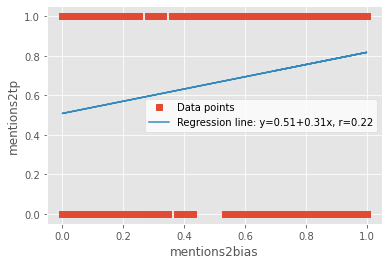

In [99]:
import matplotlib.pyplot as plt

slope, intercept, r, p, stderr = scipy.stats.linregress(mentions2scores, mentions2tp)

plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.plot(mentions2scores, mentions2tp, linewidth=0, marker='s', label='Data points')
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
ax.plot(mentions2scores, intercept + slope * mentions2scores, label=line)
ax.set_xlabel('mentions2bias')
ax.set_ylabel('mentions2tp')
ax.legend(facecolor='white')
plt.show()

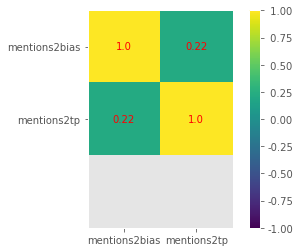

In [69]:
corr_matrix = np.corrcoef(mentions2bias, mentions2tp).round(decimals=2)
fig, ax = plt.subplots()
im = ax.imshow(corr_matrix)
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('mentions2bias', 'mentions2tp'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('mentions2bias', 'mentions2tp'))
ax.set_ylim(2.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, corr_matrix[i, j], ha='center', va='center', color='r')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()